# Partial Least Squares Regression (PLSR)
The aim of including PLSR was to evaluate whether dependent variables (electrisity and district heat) can be predicted from the independent variables. The analysis first found the number of components that will minimze MSE. Using Scikit Learn’ PLSRegression with the suggested number of components. The actual vs. predictied is showed as well as the RMSE and $R^2$.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None) # hide settingwithcopywarning

In [3]:
data_raw = pd.read_csv('data_more_time_features.csv')
data_raw['Time'] = pd.to_datetime(data_raw['Time'])
data_raw = data_raw.set_index('Time')

def standardize(df):
    scaler = StandardScaler()
    numerical_columns = df.select_dtypes(include=['number']).columns
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

data = standardize(data_raw)

In [4]:
n = len(data)
train_end = int(n * 0.7)
val_end = int(n * 0.9)  # 70% + 20% = 90%

data_train = data.iloc[:train_end]
data_val = data.iloc[train_end:val_end]
data_test = data.iloc[val_end:]

## PLSR

In [6]:
def run_plsr(data_train, data_val, data_test, y_columns, plot=True):
    
    # Split into X and Y for train, val, and test
    X_train = data_train.drop(columns=y_columns).values
    Y_train = data_train[y_columns].values

    X_val = data_val.drop(columns=y_columns).values
    Y_val = data_val[y_columns].values

    X_test = data_test.drop(columns=y_columns).values
    Y_test = data_test[y_columns]

    # Set max number of components
    max_components = min(X_train.shape[0], X_train.shape[1])
    rmse_val = []

    # Loop through component counts and evaluate on validation set
    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n)
        pls.fit(X_train, Y_train)
        Y_val_pred = pls.predict(X_val)
        mse = mean_squared_error(Y_val, Y_val_pred)
        rmse_val.append(np.sqrt(mse))

    # Plot RMSE vs. number of components
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, max_components + 1), rmse_val, marker='o')
        plt.xlabel('Number of PLS Components')
        plt.ylabel('Validation RMSE')
        plt.title('PLSR: Component Selection via Validation Set')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Choose best number of components and fit on combined train+val
    optimal_n = np.argmin(rmse_val) + 1
    print(f"Optimal number of components: {optimal_n}")

    pls_opt = PLSRegression(n_components=optimal_n)
    data_trainval = pd.concat([data_train, data_val])
    X_trainval = data_trainval.drop(columns=y_columns).values
    Y_trainval = data_trainval[y_columns].values
    pls_opt.fit(X_trainval, Y_trainval)

    # Predict on test set
    Y_pred = pls_opt.predict(X_test)
    Y_pred_df = pd.DataFrame(Y_pred, columns=y_columns, index=data_test.index)

    # Prepare results dictionary
    results = {}
    for target in y_columns:
        y_true = Y_test[target]
        y_pred = Y_pred_df[target]
        results[target] = {
            'y_test': y_true,
            'y_pred': y_pred,
            'rmse': mean_squared_error(y_true, y_pred, squared=False),
            'r2': r2_score(y_true, y_pred)}

    # Add fitted model for VIP analysis
    results['model'] = pls_opt

    return results, Y_pred_df

In [7]:
def plot_predictions(results, variables_to_pred):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    axes = axes.flatten()
    
    for idx, target in enumerate(variables_to_pred):
        y_test = results[target]['y_test']
        y_pred = results[target]['y_pred']
        rmse = results[target]['rmse']
        r2 = results[target]['r2']
        
        ax = axes[idx]
        ax.plot(y_test.index, y_test, label='Actual', color='#4c72c7', alpha=0.7)
        ax.plot(y_test.index, y_pred, label='Predicted', color='#df4e52', linestyle='-', alpha=0.7)
        ax.set_title(f"PLSR Predictions {target}\nRMSE: {rmse:.2f}, R²: {r2:.2f}", fontsize=15)
        ax.set_xlabel("Date", fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        ax.legend(loc='upper right', fontsize=9)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True)
        plt.setp(ax.get_xticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.show()
    return fig

# Variable Importance in Projection (used for plotting)
def VIP(pls_model):
    """
    Calculates VIP scores for a PLS model.
    Args:
        pls_model: Fitted PLSRegression object.
    Returns:
        Array of VIP scores for each feature.
    """
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_
    p, h = w.shape  

    # Calculate VIP scores for each feature
    vips = np.zeros(p)
    s = np.diag(np.dot(t.T, t))  
    for i in range(p):
        for j in range(h):
            vips[i] += (w[i, j]**2 * s[j]) * (q[0,j]**2 / np.sum(q**2 * s))
    vips = np.sqrt(p * vips)
    return vips


--- Running and plotting PLSR for: ['el_ur', 'district_heat_ur'] ---
Optimal number of components: 13


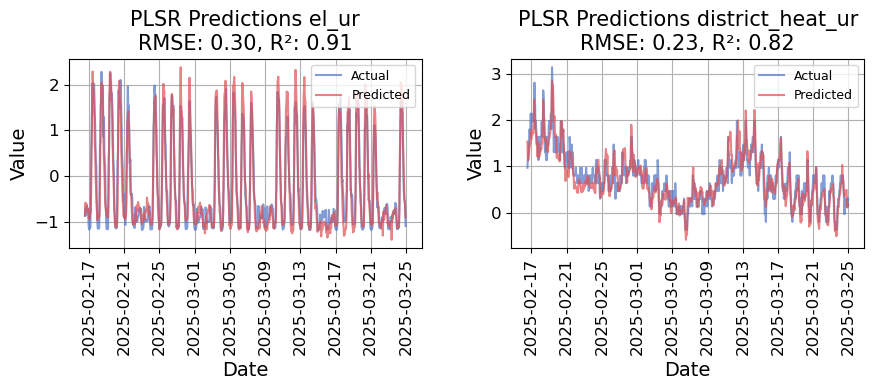


--- Running and plotting PLSR for: ['el_bikuben', 'district_heat_bikuben'] ---
Optimal number of components: 6


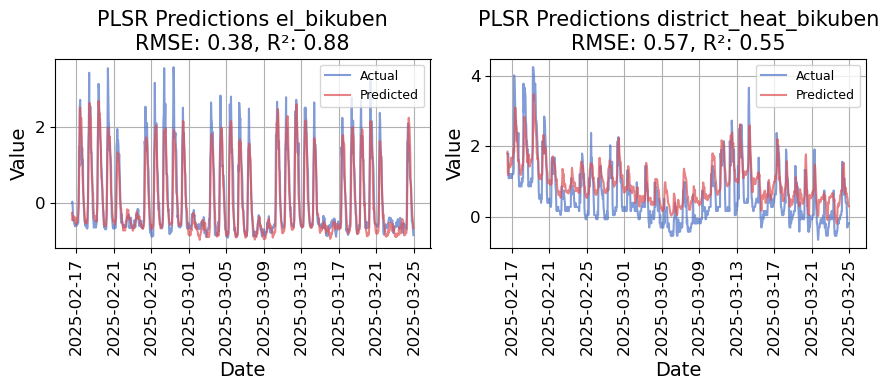


--- Running and plotting PLSR for: ['el_sor', 'district_heat_sor'] ---
Optimal number of components: 17


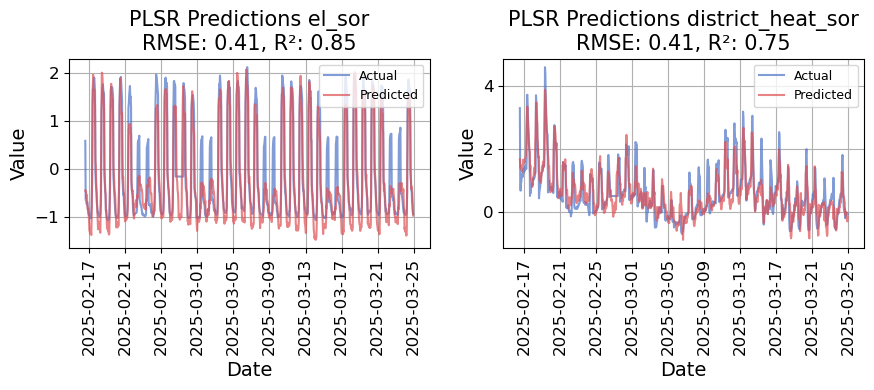


--- Running and plotting PLSR for: ['el_ka', 'district_heat_ka'] ---
Optimal number of components: 2


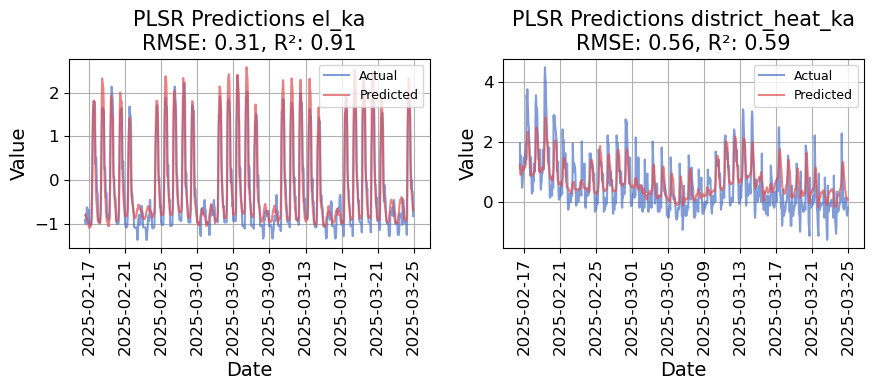


--- Running and plotting PLSR for: ['el_biotek', 'district_heat_biotek'] ---
Optimal number of components: 16


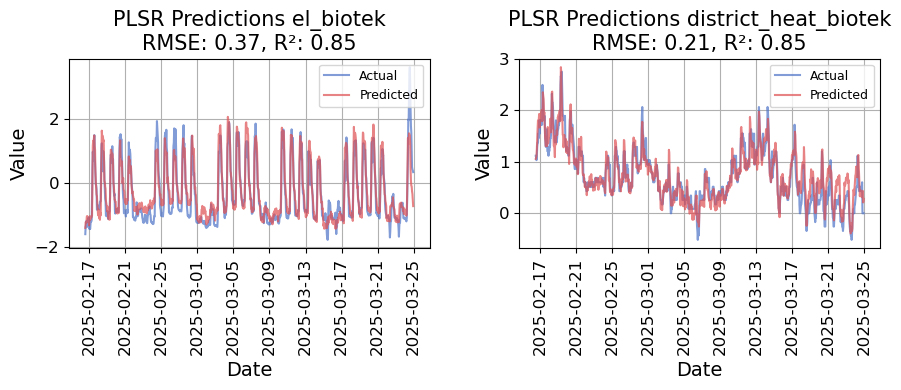


--- Running and plotting PLSR for: ['el_tf', 'district_heat_tf'] ---
Optimal number of components: 2


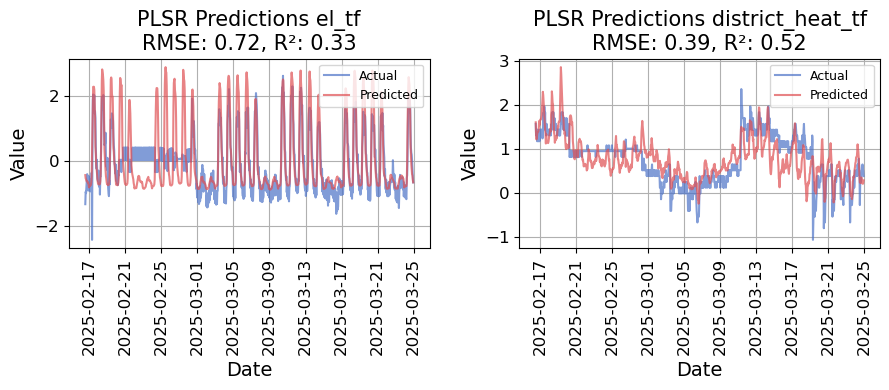

In [8]:
Y_sets = [['el_ur', 'district_heat_ur'],
         ['el_bikuben','district_heat_bikuben',],
         ['el_sor', 'district_heat_sor'],
         ['el_ka', 'district_heat_ka'],
         ['el_biotek', 'district_heat_biotek'],
         ['el_tf', 'district_heat_tf']]

all_results = {}
vip_results = {}

for y_columns in Y_sets:
    print(f"\n--- Running and plotting PLSR for: {y_columns} ---")
    results, _ = run_plsr(data_train, data_val, data_test, y_columns, plot=False)
    
    # Plot with save
    fig = plot_predictions(results, y_columns)
    filename = f"PLSR_{'_'.join(y_columns)}.png"
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close(fig)
    
    # Get fitted PLS model and compute VIP scores
    pls_model = results['model']
    vip_scores = VIP(pls_model)

    feature_names = data_train.drop(columns=y_columns).columns
    vip_df = pd.DataFrame({'Feature': feature_names, 'VIP': vip_scores})
    vip_df = vip_df.sort_values('VIP', ascending=False)
    vip_results['_'.join(y_columns)] = vip_df


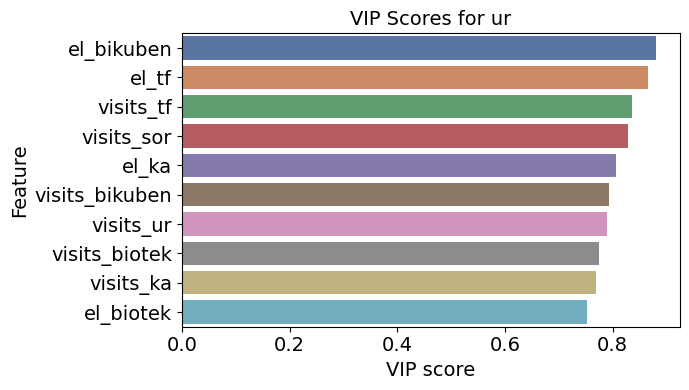

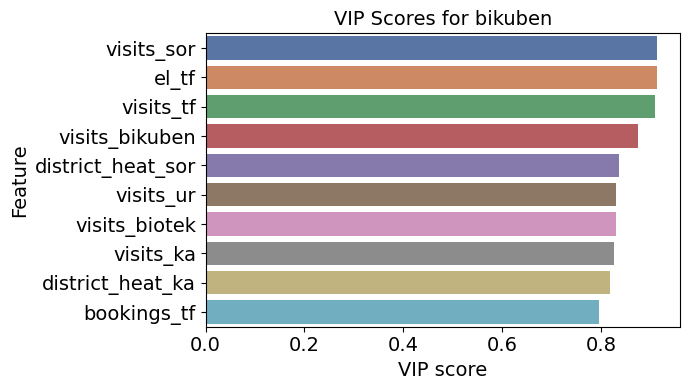

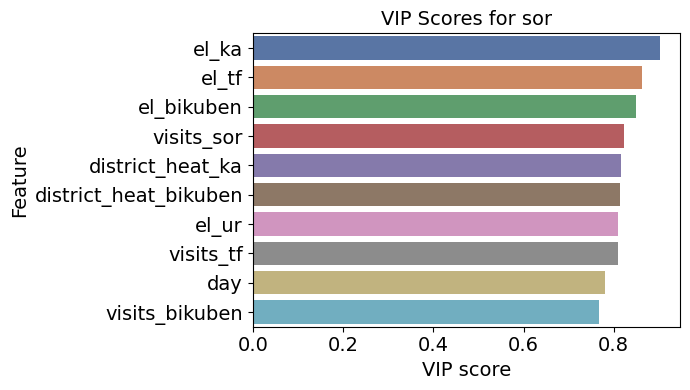

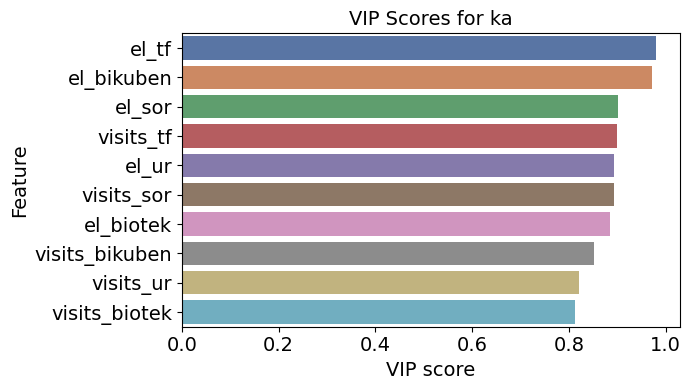

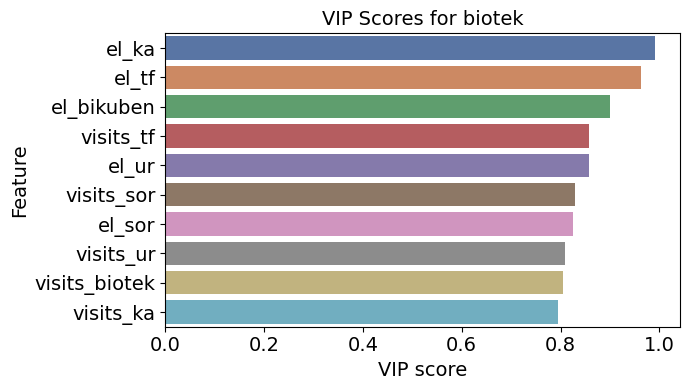

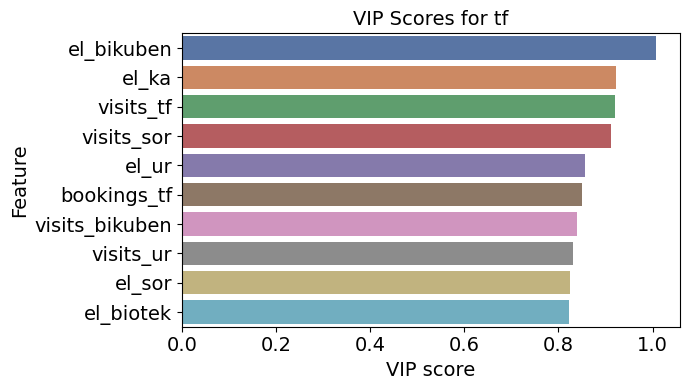

In [9]:
titles = {'el_ur_district_heat_ur': 'ur',
          'el_bikuben_district_heat_bikuben': 'bikuben',
          'el_sor_district_heat_sor': 'sor',
          'el_ka_district_heat_ka': 'ka',
          'el_biotek_district_heat_biotek': 'biotek',
          'el_tf_district_heat_tf': 'tf'}

# Loop through each key in vip_results and plot/save
for key, label in titles.items():
    plt.figure(figsize=(7, 4))
    vip_top10 = vip_results[key].sort_values(by='VIP', ascending=False).head(10) # Sort and select top 10
    sns.barplot(data=vip_top10, x='VIP', y='Feature', palette='deep')
    plt.title(f"VIP Scores for {label}", fontsize=14)
    plt.xlabel("VIP score", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.tick_params(axis='both', labelsize=14)
    plt.tight_layout()
    plt.savefig(f"PLSR VIP - {label}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

In [10]:
def plot_scores_loadings(pls_model, feature_names, target_names, title="PLSR"):
    # Compute explained variance in X
    x_var = np.var(pls_model.x_scores_, axis=0, ddof=1)
    explained = x_var / np.sum(x_var)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2]})

    # Scores plot
    scores = pls_model.x_scores_
    axes[0].scatter(scores[:, 0], scores[:, 1], alpha=0.4, s=7)
    axes[0].set_title("Scores Plot", fontsize=14)
    axes[0].set_xlabel(f"Comp 1 ({explained[0]*100:.1f}%)", fontsize=14)
    axes[0].set_ylabel(f"Comp 2 ({explained[1]*100:.1f}%)", fontsize=14)
    axes[0].grid(True)
    axes[0].tick_params(axis='both', labelsize=14)

    # Loadings plot
    loadings = pls_model.x_loadings_
    for i, feature in enumerate(feature_names):
        axes[1].arrow(0, 0, loadings[i, 0], loadings[i, 1], color='#4c72c7', alpha=0.4, head_width=0.01)
        axes[1].text(loadings[i, 0]*1.05, loadings[i, 1]*1.05, feature, fontsize=11)
    axes[1].set_title("Loadings Plot", fontsize=14)
    axes[1].set_xlabel(f"Comp 1 ({explained[0]*100:.1f}%)", fontsize=14)
    axes[1].set_ylabel(f"Comp 2 ({explained[1]*100:.1f}%)", fontsize=14)
    axes[1].tick_params(axis='both', labelsize=14)

    fig.suptitle(title, fontsize=13)
    plt.tight_layout()
    plt.show()
    return fig



--- Running and plotting PLSR for: ('el_ur', 'district_heat_ur') ---
Optimal number of components: 13


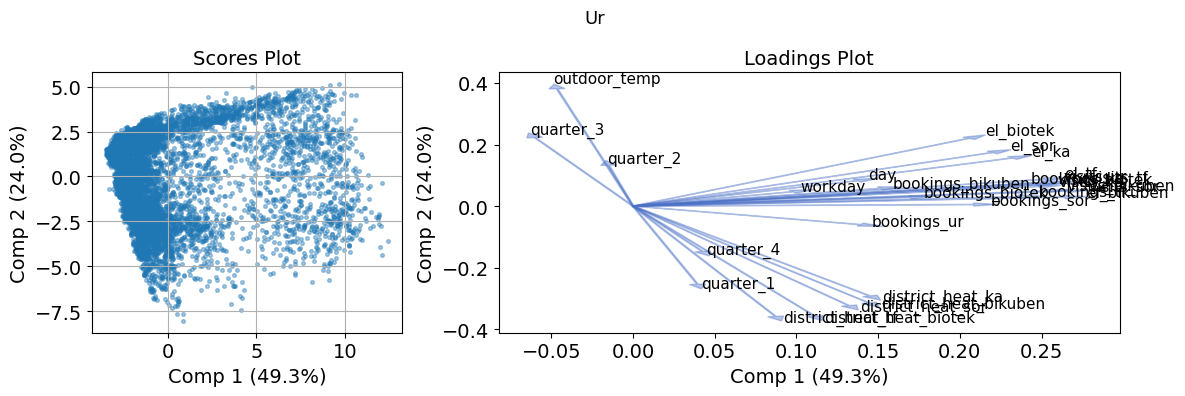


--- Running and plotting PLSR for: ('el_bikuben', 'district_heat_bikuben') ---
Optimal number of components: 6


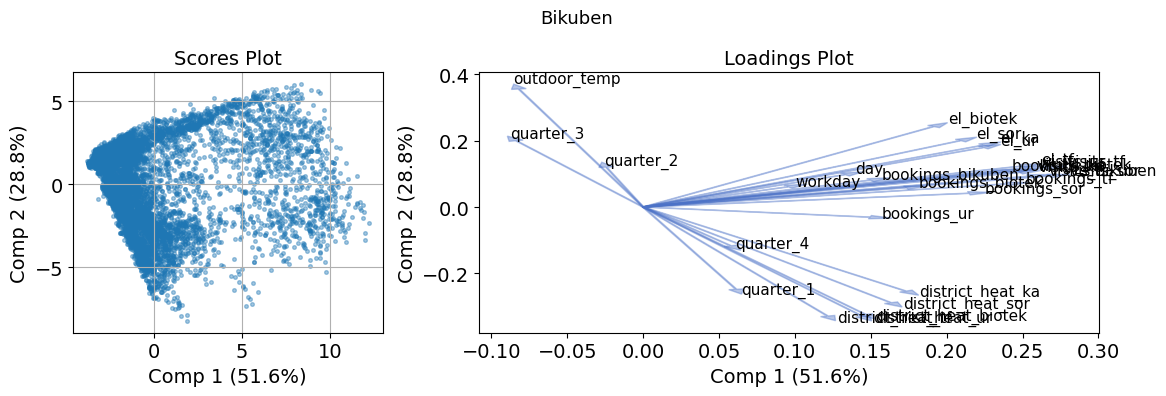


--- Running and plotting PLSR for: ('el_sor', 'district_heat_sor') ---
Optimal number of components: 17


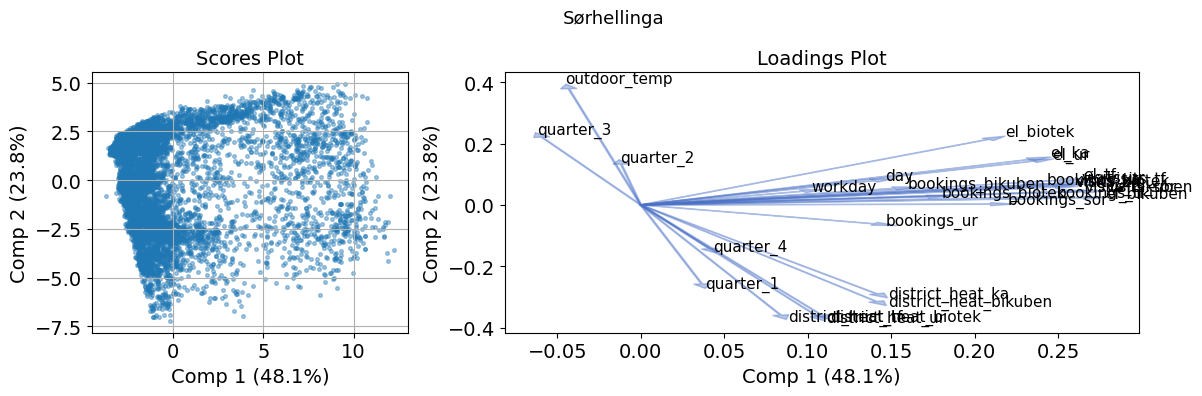


--- Running and plotting PLSR for: ('el_ka', 'district_heat_ka') ---
Optimal number of components: 2


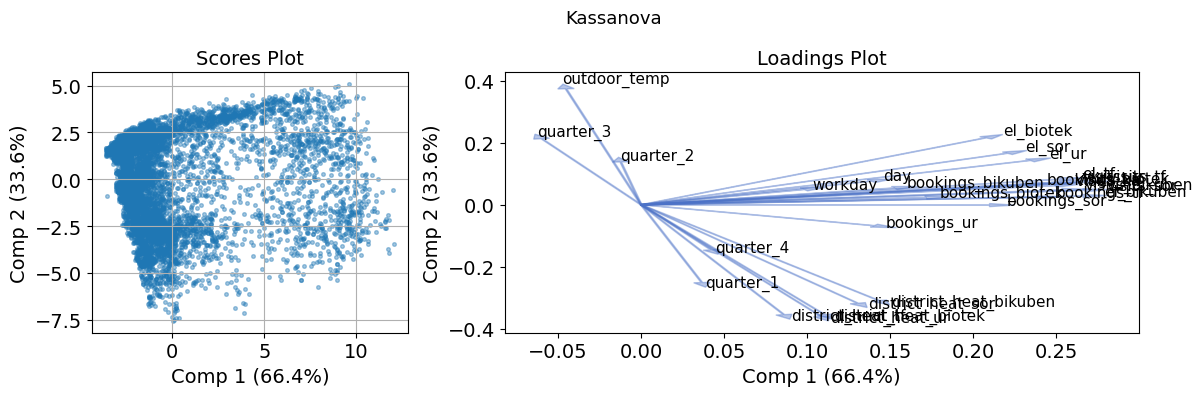


--- Running and plotting PLSR for: ('el_biotek', 'district_heat_biotek') ---
Optimal number of components: 16


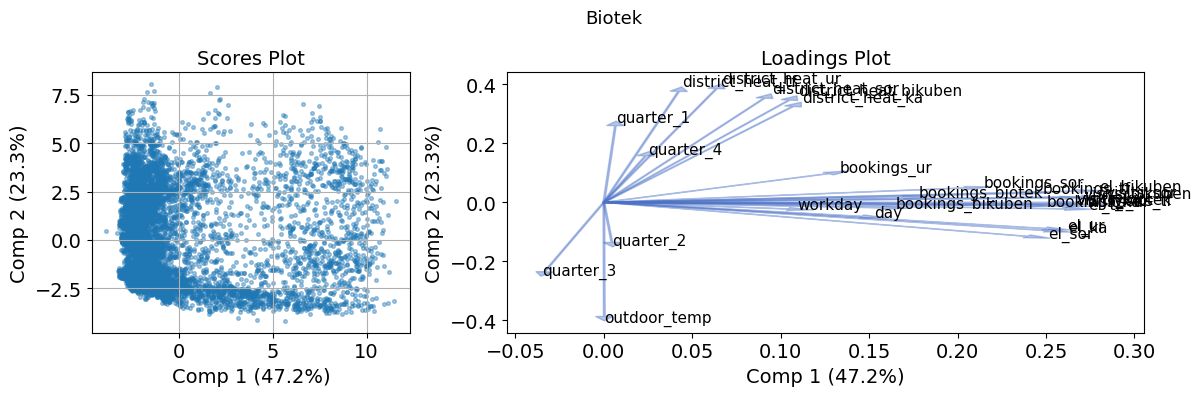


--- Running and plotting PLSR for: ('el_tf', 'district_heat_tf') ---
Optimal number of components: 2


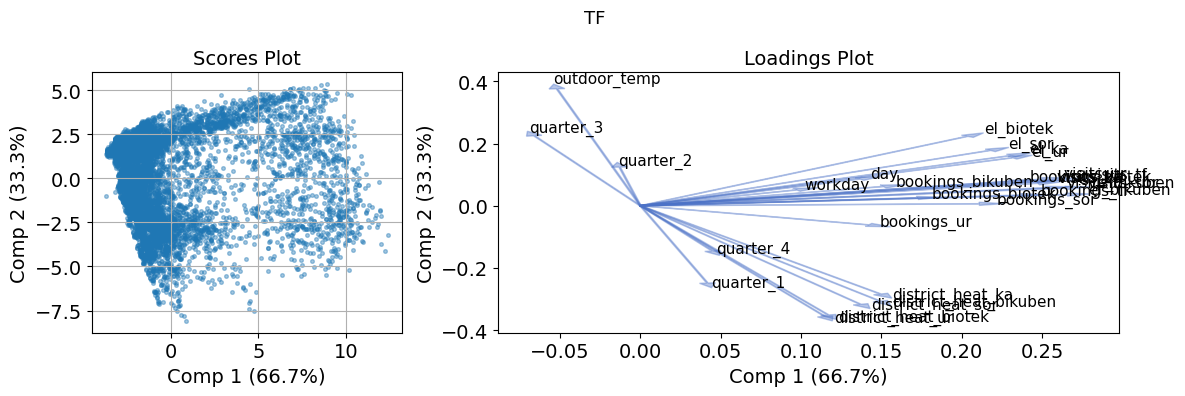

In [11]:
# Define readable titles for each Y set
titles = {('el_ur', 'district_heat_ur'): 'Ur',
        ('el_bikuben', 'district_heat_bikuben'): 'Bikuben',
        ('el_sor', 'district_heat_sor'): 'Sørhellinga',
        ('el_ka', 'district_heat_ka'): 'Kassanova',
        ('el_biotek', 'district_heat_biotek'): 'Biotek',
        ('el_tf', 'district_heat_tf'): 'TF'}

Y_sets = list(titles.keys())

for y_columns in Y_sets:
    print(f"\n--- Running and plotting PLSR for: {y_columns} ---")
    results, _ = run_plsr(data_train, data_val, data_test, list(y_columns), plot=False)

    pls_model = results['model']
    feature_names = data_train.drop(columns=list(y_columns)).columns
    title = titles[y_columns] 

    fig_comp = plot_scores_loadings(pls_model, feature_names, list(y_columns), title=title)
    fig_comp.savefig(f"PLSR Scores_Loadings_{title}.png", dpi=300, bbox_inches="tight")
    plt.close(fig_comp)
